# Решение задачи регрессии точек с использованием модели YoloV5 и обучением по нескольким примерам

В ноутбуке проверяется подход к решению задачи регрессии ключевых точек с помощью построения модели регрессии на feature map предобученной модели

* получаем feature map с помощью модели YoloV5
* тренируем модели линейной регрессии решать задачу k-points

Использованы картинки из датасета https://www.kaggle.com/datasets/crawford/cat-dataset

In [1]:
import pathlib
import random
import sys

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.cli import tqdm

sys.path.append("../yolov5")

In [2]:
from assh_utils import Batch

In [3]:
import os

root = "/home/asciishell/s3/asciishell-fsod/cats/CAT_00/"
images = [root + x for x in os.listdir(root) if x.endswith(".jpg")]
len(images)

1706

In [4]:
from models.common import AutoShape, DetectMultiBackend

In [5]:
model = AutoShape(DetectMultiBackend("./yolov5x.pt"))

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.7 GFLOPs
Adding AutoShape... 


In [6]:
%matplotlib inline

## Feature map visualisation

In [14]:
x = model(images[0], profile=pathlib.Path("vis"))

Saving vis/stage0_Conv_features.png... (32/80)
Saving vis/stage1_Conv_features.png... (32/160)
Saving vis/stage2_C3_features.png... (32/160)
Saving vis/stage3_Conv_features.png... (32/320)
Saving vis/stage4_C3_features.png... (32/320)
Saving vis/stage5_Conv_features.png... (32/640)
Saving vis/stage6_C3_features.png... (32/640)
Saving vis/stage7_Conv_features.png... (32/1280)
Saving vis/stage8_C3_features.png... (32/1280)
Saving vis/stage9_SPPF_features.png... (32/1280)
Saving vis/stage10_Conv_features.png... (32/640)
Saving vis/stage11_Upsample_features.png... (32/640)
Saving vis/stage12_Concat_features.png... (32/1280)
Saving vis/stage13_C3_features.png... (32/640)
Saving vis/stage14_Conv_features.png... (32/320)
Saving vis/stage15_Upsample_features.png... (32/320)
Saving vis/stage16_Concat_features.png... (32/640)
Saving vis/stage17_C3_features.png... (32/320)
Saving vis/stage18_Conv_features.png... (32/320)
Saving vis/stage19_Concat_features.png... (32/640)
Saving vis/stage20_C3_fea

We can fisualise feature map in the intermediate layers

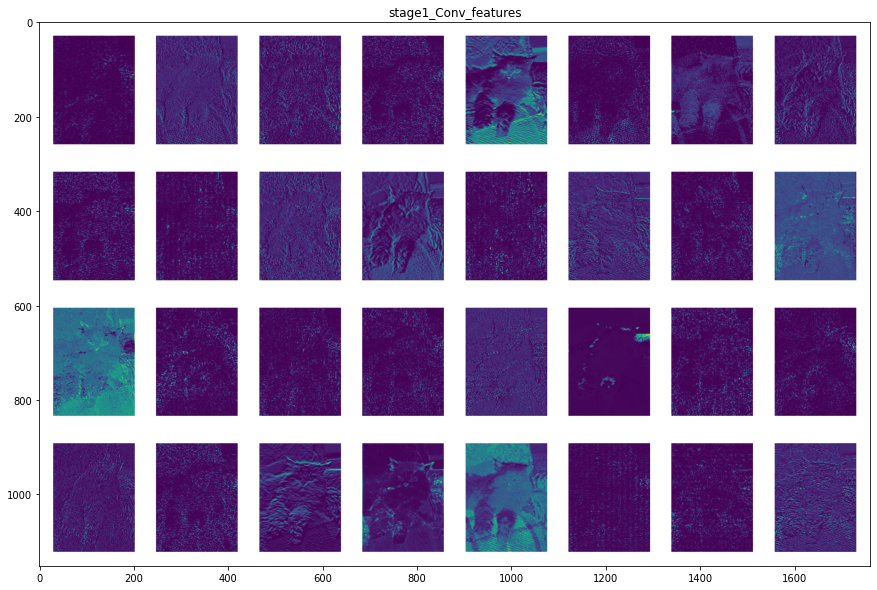

In [16]:
im = cv2.imread("vis/stage1_Conv_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage1_Conv_features")
plt.imshow(im)
plt.show()

Features are taken from 9th layer - last yolo backbone layer

see https://github.com/AsciiShell/yolov5/blob/master/models/yolov5x.yaml
```
# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]
```

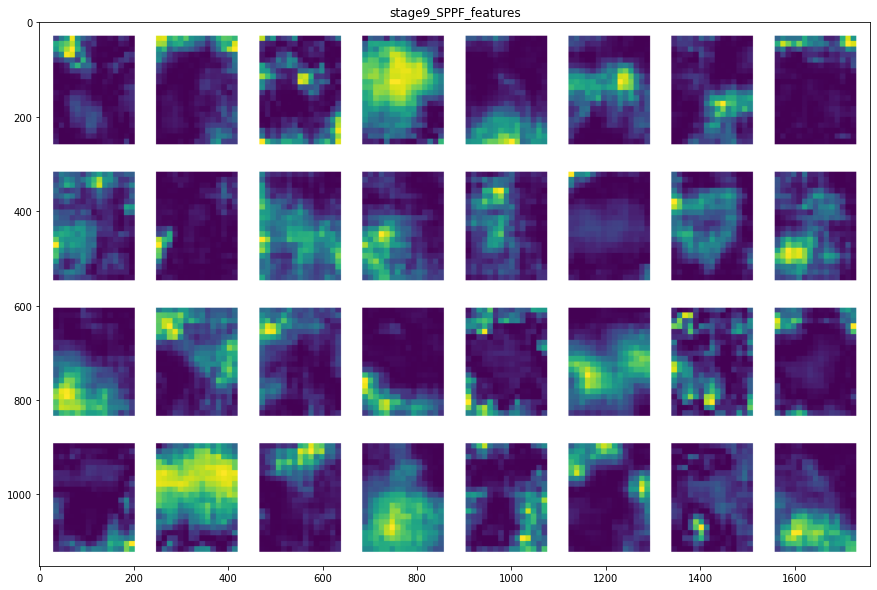

In [17]:
im = cv2.imread("vis/stage9_SPPF_features.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(25, 10))
plt.title("stage9_SPPF_features")
plt.imshow(im)
plt.show()

## Model training

Для обучения будем брать центральный вектор из feature map + еще 8 ближайших векторов

Для каждого из 9 векторов target будет немного отличаться (k-points вычисляются осносительно центра выбранного вектора)

При инференсе реализован предикт для 9 векторов и усреднение предсказаний

In [7]:
for names in tqdm(Batch(images, 9)):
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])
    break

  0%|          | 0/190 [00:00<?, ?it/s]


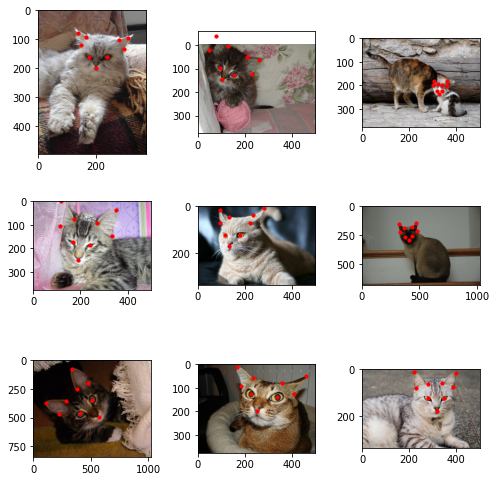

In [8]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(len(cat_target)):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(cat_target[i][:9], cat_target[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

In [9]:
BATCH_SIZE = 32
TRAIN_SIZE = 16

feature map Yolo для применения в батче и для одной картинки сильно отличается, поэтому будем заранее использовать препроцессор к картинке - чтобы размеры feature map совпадали для разных изображений

также аналогичный процессинг применяем и для kpoints

In [10]:
def letterbox(
    im, key_x, key_y, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32
):
    """
    source https://github.com/ultralytics/yolov5/blob/master/utils/augmentations.py#L91
    В функцию добавлено преобразование для kpoints 
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
        scale_x = shape[1] / new_unpad[0]
        scale_y = shape[0] / new_unpad[1]
        key_x = key_x / scale_x
        key_y = key_y / scale_y
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    key_x += left
    key_y += top
    return im, ratio, (dw, dh), (key_x, key_y)


def scale_coords(img1_shape, img0_shape, key_x, key_y):
    """
    source https://github.com/ultralytics/yolov5/blob/master/utils/general.py#L709
    Функция исправлена для применения преобразования к kpoints
    """
    # Rescale coords (xyxy) from img1_shape to img0_shape
    # calculate from img0_shape
    key_x = key_x.copy()
    key_y = key_y.copy()
    gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
    pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    key_x -= pad[0]
    key_y -= pad[1]
    key_x /= gain
    key_y /= gain
    return key_x, key_y


def preproc_img(im, key_x, key_y):
    """
    Функция предобработки изображения 
    Применение данной функции к каждому изображению позволяет
    получать feature map одинакового размера для всех изображений по отдельности
    (как если бы подавались все изображения в одном батче)
    """
    key_x = key_x.copy()
    key_y = key_y.copy()
    im = im.copy()
    res = letterbox(im, key_x, key_y, [640, 640, 32], auto=False)
    im, keys = res[0], res[-1]
    im = im.transpose((2, 0, 1))[::-1]
    im = np.ascontiguousarray(im)
    return im, keys[0], keys[1]

In [19]:
def predict(X, regr, inputs):
    """
    Получение, усреднение и обратное преобразование предсказаний
    """
    prediction = []
    output = regr.predict(X).reshape((-1, 9, 18))
    feature_map_size = 64

    for i in range(len(output)):
        h = inputs[i]["height"]
        w = inputs[i]["width"]
        pred = []
        for fm in output[i]:
            x_output = fm[:9] * feature_map_size
            y_output = fm[9:] * feature_map_size
            x_output += (np.round(np.ceil(640 / feature_map_size) / 2) + 0.5) * feature_map_size
            y_output += (np.round(np.ceil(640 / feature_map_size) / 2) + 0.5) * feature_map_size
            key_x, key_y = scale_coords((640, 640), (h, w), x_output, y_output)
            pred.append(np.hstack([key_x, key_y]))
        prediction.append(np.array(pred).mean(axis=0))
    return prediction

Выберем оптимальное кол-во PCA

In [12]:
metrics = []
for names in tqdm(Batch(images, BATCH_SIZE)):
    if len(names) < BATCH_SIZE:
        break
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

    # make train and test datasets
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        inputs.append({"height": height, "width": width})

        feature_map_size = 64
        # середина feature map
        x = round(np.ceil(640 / feature_map_size) / 2)
        y = round(np.ceil(640 / feature_map_size) / 2)

        im_, x_target, y_target = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
        # apply model
        xx = model([im_])
        t = torch.load("tensor.pt")

        if i < TRAIN_SIZE:
            for x_ in range(x - 1, x + 2):
                for y_ in range(y - 1, y + 2):
                    features_train.append(np.array(t[0, :, y_ - 1, x_ - 1]))
                    x_center = feature_map_size * (x_ + 0.5)
                    y_center = feature_map_size * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / feature_map_size, (y_target - y_center) / feature_map_size])
                    )

        for x_ in range(x - 1, x + 2):
            for y_ in range(y - 1, y + 2):
                features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

    features_train = np.array(features_train)
    features_test = np.array(features_test)

    # fit regression
    prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
    for p in prange:
        pca = PCA(p, random_state=42)
        pca_train = pca.fit_transform(features_train)
        regr = LinearRegression().fit(pca_train, target_train)

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        metrics.append(
            [
                p,
                mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
            ]
        )

    break

  0%|          | 0/54 [00:12<?, ?it/s]


In [13]:
features_train.shape

(144, 1280)

In [14]:
metrics = pd.DataFrame(metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,81.144266,77.844055,0.423738,0.463866
1,2,75.770818,74.262057,0.504423,0.502916
2,3,74.397146,72.952081,0.524831,0.490881
3,5,61.894770,71.448239,0.663665,0.469470
4,6,58.173732,69.456011,0.691939,0.518242
5,7,49.922616,69.180982,0.775684,0.496599
6,9,39.835317,67.251394,0.848311,0.524078
7,12,31.191030,66.857372,0.908397,0.493414
8,15,17.045257,63.944510,0.962924,0.546345
9,19,10.419761,63.410972,0.988150,0.536527


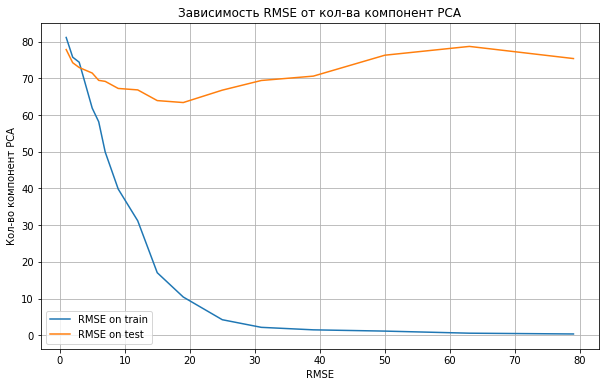

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["pca_cnt"], metrics["train_rmse"], label="RMSE on train")
plt.plot(metrics["pca_cnt"], metrics["test_rmse"], label="RMSE on test")
plt.title("Зависимость RMSE от кол-ва компонент PCA")
plt.xlabel("RMSE")
plt.ylabel("Кол-во компонент PCA")
plt.legend()
plt.grid()
plt.show()

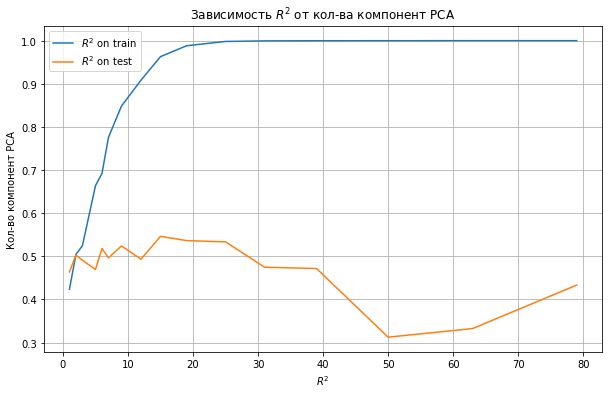

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(metrics["pca_cnt"], metrics["train_r2"], label="$R^2$ on train")
plt.plot(metrics["pca_cnt"], metrics["test_r2"], label="$R^2$ on test")
plt.title("Зависимость $R^2$ от кол-ва компонент PCA")
plt.xlabel("$R^2$")
plt.ylabel("Кол-во компонент PCA")
plt.legend()
plt.grid()
plt.show()

In [18]:
metrics = []
for names in tqdm(Batch(images, BATCH_SIZE)):
    if len(names) < BATCH_SIZE:
        break
    # read images and data
    cat_names = names.copy()
    cat_target = []
    for cat_name in cat_names:
        with open(cat_name + ".cat") as f:
            cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
    cat_target = np.array(cat_target)
    cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

    # make train and test datasets
    features_train = []
    features_test = []
    inputs = []
    target_train = []
    for i in range(len(cat_target)):
        im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
        height, width = im.shape[:2]
        inputs.append({"height": height, "width": width})

        feature_map_size = 64
        # середина feature map
        x = round(np.ceil(640 / feature_map_size) / 2)
        y = round(np.ceil(640 / feature_map_size) / 2)

        im_, x_target, y_target = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
        # apply model
        xx = model([im_])
        t = torch.load("tensor.pt")

        if i < TRAIN_SIZE:
            for x_ in range(x - 1, x + 2):
                for y_ in range(y - 1, y + 2):
                    features_train.append(np.array(t[0, :, y_ - 1, x_ - 1]))
                    x_center = feature_map_size * (x_ + 0.5)
                    y_center = feature_map_size * (y_ + 0.5)
                    target_train.append(
                        np.hstack([(x_target - x_center) / feature_map_size, (y_target - y_center) / feature_map_size])
                    )

        for x_ in range(x - 1, x + 2):
            for y_ in range(y - 1, y + 2):
                features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

    features_train = np.array(features_train)
    features_test = np.array(features_test)

    # fit regression
    pca = PCA(15, random_state=42)
    pca_train = pca.fit_transform(features_train)
    regr = LinearRegression().fit(pca_train, target_train)

    # predict key points
    pca_test = pca.transform(features_test)
    prediction = predict(pca_test, regr, inputs)

    metrics.append(
        [
            mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
            mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
            r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
            r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
        ]
    )

 98%|█████████▊| 53/54 [14:05<00:15, 15.95s/it]


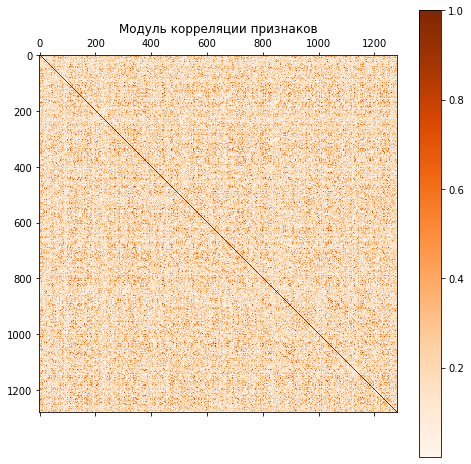

In [19]:
plt.figure(figsize=(8, 8))
plt.matshow(np.abs(np.corrcoef(features_train, rowvar=False)), cmap="Oranges", fignum=1)
plt.title("Модуль корреляции признаков")
plt.colorbar()
plt.show()

In [20]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,17.473166,79.896837,0.967606,0.415685
std,6.475719,18.308884,0.027239,0.290745
min,8.137408,44.706658,0.828638,-0.559156
50%,16.902130,74.424040,0.975224,0.509423
max,41.302928,117.559001,0.994282,0.766245


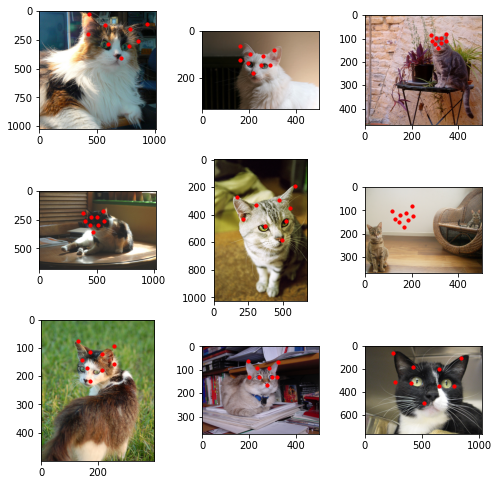

In [21]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

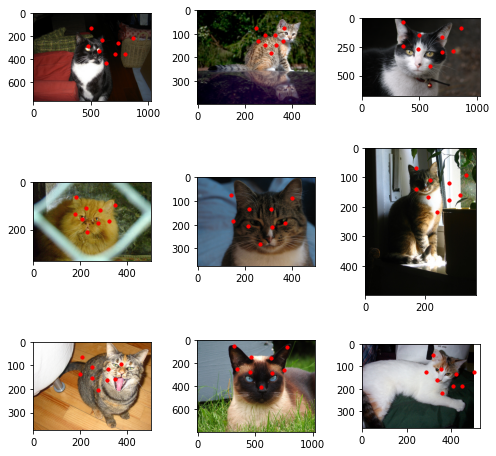

In [22]:
plt.figure(figsize=(7, 7), facecolor="w")
for i in range(9):
    plt.subplot(3, 3, i + 1)
    i = BATCH_SIZE - 9 + i
    im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.scatter(prediction[i][:9], prediction[i][9:], s=10, c="red")
plt.tight_layout()
plt.show()

Некоторые (близкие) вектора feature map действительно сильно коррелируют между собой

(1280, 3, 3)


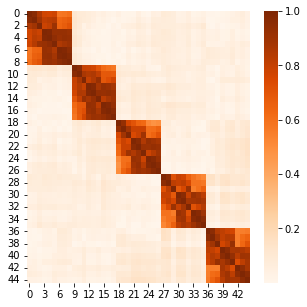

In [23]:
f = t[0, :, y - 1 : y + 2, x - 1 : x + 2].detach().numpy()
print(f.shape)
f = f.reshape((256, -1))
f = np.abs(pd.DataFrame(f).corr())
plt.figure(figsize=(5, 5), facecolor="w")
sns.heatmap(f, cmap=plt.cm.Oranges);

In [24]:
np.array(features_train).shape, np.array(target_train).shape

((144, 1280), (144, 18))

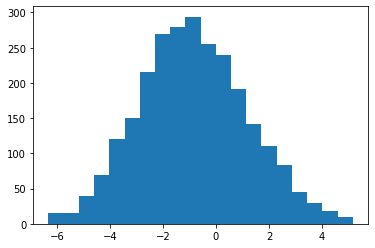

In [25]:
plt.hist(np.array(target_train).ravel(), bins=20);

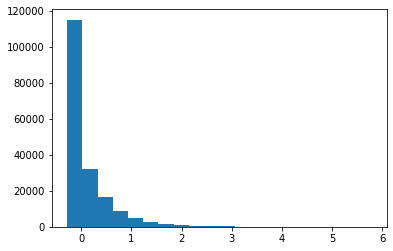

In [26]:
plt.hist(np.array(features_train).ravel(), bins=20);

## Augmentations

Исследуем влияние аугментации на решение задачи kpoints
* Наличие аугментаций с цветом и яркостью
* Наличие аугментаций с поворотом
* Наличие аугментаций с кропом
* Кол-во аугментаций

In [16]:
def pca_optimal(rotate_flag, crop_flag, n_aug):
    transform1_compose = [
        A.HueSaturationValue(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform1_compose.append(A.Rotate(limit=15, p=1))
    transform1 = A.Compose(
        transform1_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    transform2_compose = [
        A.RGBShift(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform2_compose.append(A.ShiftScaleRotate(rotate_limit=15, p=1))
    transform2 = A.Compose(
        transform2_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    metrics = []
    for names in tqdm(Batch(images, BATCH_SIZE)):
        if len(names) < BATCH_SIZE:
            break
        # read images and data
        cat_names = names.copy()
        cat_target = []
        for cat_name in cat_names:
            with open(cat_name + ".cat") as f:
                cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
        cat_target = np.array(cat_target)
        cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

        # make train and test datasets
        features_train = []
        features_test = []
        inputs = []
        target_train = []
        for i in range(len(cat_target)):
            im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
            height, width = im.shape[:2]
            inputs.append({"height": height, "width": width})

            feature_map_size = 64
            # середина feature map
            x = round(np.ceil(640 / feature_map_size) / 2)
            y = round(np.ceil(640 / feature_map_size) / 2)

            im_, key_x, key_y = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
            # apply model
            xx = model([im_])
            t = torch.load("tensor.pt")

            if i < TRAIN_SIZE:
                imgs = []
                cat_targets = [np.hstack([key_x, key_y])]
                kp_target = list(zip(cat_target[i][:9], cat_target[i][9:]))

                transform3 = A.Compose(
                    [
                        A.RandomSizedCrop(
                            min_max_height=(int(min(height, width) * 0.9), min(height, width)),
                            height=height,
                            width=width,
                            p=1,
                        ),
                        # A.OneOf([A.Rotate(p=0.8), A.ShiftScaleRotate(p=0.8)], p=1),
                        A.OneOf([A.HueSaturationValue(p=1), A.RGBShift(p=1)], p=1),
                        A.RandomBrightnessContrast(p=1),
                    ],
                    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
                )

                for seed in range(n_aug):
                    random.seed(seed)
                    transformed = transform1(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    transformed = transform2(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    if crop_flag:
                        transformed = transform3(image=im, keypoints=kp_target)
                        kp = np.array(transformed["keypoints"])
                        im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                        imgs.append(im_)
                        cat_targets.append(np.hstack([key_x, key_y]))

                # apply model
                xx = model(imgs)
                tt = torch.load("tensor.pt")
                tt = torch.cat((t, tt))

                for j in range(tt.shape[0]):
                    for x_ in range(x - 1, x + 2):
                        for y_ in range(y - 1, y + 2):
                            x_target = cat_targets[j][:9]
                            y_target = cat_targets[j][9:]
                            features_train.append(np.array(tt[j, :, y_ - 1, x_ - 1]))
                            x_center = feature_map_size * (x_ + 0.5)
                            y_center = feature_map_size * (y_ + 0.5)
                            target_train.append(
                                np.hstack(
                                    [(x_target - x_center) / feature_map_size, (y_target - y_center) / feature_map_size]
                                )
                            )

            for x_ in range(x - 1, x + 2):
                for y_ in range(y - 1, y + 2):
                    features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

        features_train = np.array(features_train)
        features_test = np.array(features_test)

        # fit regression
        prange = np.unique(np.logspace(0, 1.9, 20).astype(int))
        for p in prange:
            pca = PCA(p, random_state=42)
            pca_train = pca.fit_transform(features_train)
            regr = LinearRegression().fit(pca_train, target_train)

            # predict key points
            pca_test = pca.transform(features_test)
            prediction = predict(pca_test, regr, inputs)

            metrics.append(
                [
                    p,
                    mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                    mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                    r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                    r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
                ]
            )

        break
    return metrics

In [17]:
def fit_pca(rotate_flag, crop_flag, n_aug, n_pca):
    transform1_compose = [
        A.HueSaturationValue(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform1_compose.append(A.Rotate(limit=15, p=1))
    transform1 = A.Compose(
        transform1_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    transform2_compose = [
        A.RGBShift(p=1),
        A.RandomBrightnessContrast(p=1),
    ]
    if rotate_flag:
        transform2_compose.append(A.ShiftScaleRotate(rotate_limit=15, p=1))
    transform2 = A.Compose(
        transform2_compose,
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )

    metrics = []
    for names in tqdm(Batch(images, BATCH_SIZE)):
        if len(names) < BATCH_SIZE:
            break
        # read images and data
        cat_names = names.copy()
        cat_target = []
        for cat_name in cat_names:
            with open(cat_name + ".cat") as f:
                cat_target.append([int(x) for x in f.read().split(" ")[1:-1]])
        cat_target = np.array(cat_target)
        cat_target = np.hstack([cat_target[:, ::2], cat_target[:, 1::2]])

        # make train and test datasets
        features_train = []
        features_test = []
        inputs = []
        target_train = []
        for i in range(len(cat_target)):
            im = cv2.imread(cat_names[i], cv2.IMREAD_COLOR)
            height, width = im.shape[:2]
            inp = [{"height": height, "width": width}]
            inputs.append(inp[0])

            feature_map_size = 64
            # середина feature map
            x = round(np.ceil(640 / feature_map_size) / 2)
            y = round(np.ceil(640 / feature_map_size) / 2)

            im_, key_x, key_y = preproc_img(im, cat_target[i][:9], cat_target[i][9:])
            # apply model
            xx = model([im_])
            t = torch.load("tensor.pt")

            if i < TRAIN_SIZE:
                imgs = []
                cat_targets = [np.hstack([key_x, key_y])]
                kp_target = list(zip(cat_target[i][:9], cat_target[i][9:]))

                transform3 = A.Compose(
                    [
                        A.RandomSizedCrop(
                            min_max_height=(int(min(height, width) * 0.9), min(height, width)),
                            height=height,
                            width=width,
                            p=1,
                        ),
                        # A.OneOf([A.Rotate(p=0.8), A.ShiftScaleRotate(p=0.8)], p=1),
                        A.OneOf([A.HueSaturationValue(p=1), A.RGBShift(p=1)], p=1),
                        A.RandomBrightnessContrast(p=1),
                    ],
                    keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
                )

                for seed in range(n_aug):
                    random.seed(seed)
                    transformed = transform1(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    transformed = transform2(image=im, keypoints=kp_target)
                    kp = np.array(transformed["keypoints"])
                    im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                    imgs.append(im_)
                    cat_targets.append(np.hstack([key_x, key_y]))

                    if crop_flag:
                        transformed = transform3(image=im, keypoints=kp_target)
                        kp = np.array(transformed["keypoints"])
                        im_, key_x, key_y = preproc_img(transformed["image"], kp[:, 0], kp[:, 1])
                        imgs.append(im_)
                        cat_targets.append(np.hstack([key_x, key_y]))

                # apply model
                xx = model(imgs)
                tt = torch.load("tensor.pt")
                tt = torch.cat((t, tt))

                for j in range(tt.shape[0]):
                    for x_ in range(x - 1, x + 2):
                        for y_ in range(y - 1, y + 2):
                            x_target = cat_targets[j][:9]
                            y_target = cat_targets[j][9:]
                            features_train.append(np.array(tt[j, :, y_ - 1, x_ - 1]))
                            x_center = feature_map_size * (x_ + 0.5)
                            y_center = feature_map_size * (y_ + 0.5)
                            target_train.append(
                                np.hstack(
                                    [(x_target - x_center) / feature_map_size, (y_target - y_center) / feature_map_size]
                                )
                            )

            for x_ in range(x - 1, x + 2):
                for y_ in range(y - 1, y + 2):
                    features_test.append(np.array(t[0, :, y_ - 1, x_ - 1]))

        features_train = np.array(features_train)
        features_test = np.array(features_test)

        # fit regression
        pca = PCA(n_pca, random_state=42)
        pca_train = pca.fit_transform(features_train)
        regr = LinearRegression().fit(pca_train, target_train)

        # predict key points
        pca_test = pca.transform(features_test)
        prediction = predict(pca_test, regr, inputs)

        metrics.append(
            [
                mean_squared_error(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE], squared=False),
                mean_squared_error(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:], squared=False),
                r2_score(cat_target[:TRAIN_SIZE], prediction[:TRAIN_SIZE]),
                r2_score(cat_target[TRAIN_SIZE:], prediction[TRAIN_SIZE:]),
            ]
        )
    return metrics

### Эксперимент 1

In [20]:
pca_metrics = pca_optimal(rotate_flag=False, crop_flag=False, n_aug=1)

  0%|          | 0/54 [00:22<?, ?it/s]


In [21]:
pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
pca_metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,81.448452,78.526261,0.419223,0.452895
1,2,74.296950,74.409923,0.521660,0.486230
2,3,74.772155,73.865020,0.519458,0.483849
3,5,63.401725,71.611931,0.647790,0.476668
4,6,58.863589,68.924613,0.688340,0.536688
5,7,46.575703,69.363273,0.799732,0.516601
6,9,40.860397,68.255994,0.838083,0.531535
7,12,34.114804,69.406406,0.898655,0.487314
8,15,22.139776,64.896181,0.942670,0.525739
9,19,18.708322,63.663893,0.963937,0.536504


In [22]:
metrics = fit_pca(rotate_flag=False, crop_flag=False, n_aug=1, n_pca=19)

 98%|█████████▊| 53/54 [18:08<00:20, 20.54s/it]


In [23]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,11.845127,81.219880,0.985993,0.403678
std,4.997300,18.431114,0.012425,0.272462
min,5.795796,46.238976,0.921754,-0.472155
50%,10.528508,77.742671,0.989530,0.482743
max,34.014804,121.608858,0.996731,0.767091


### Эксперимент 2

In [24]:
pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=1)

  0%|          | 0/54 [00:22<?, ?it/s]


In [25]:
pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
pca_metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,79.751948,80.078266,0.444846,0.393546
1,2,73.076417,73.940676,0.537905,0.443460
2,3,70.675724,74.089568,0.560674,0.440971
3,5,63.184686,76.777069,0.656763,0.391899
4,6,56.641495,72.268346,0.706909,0.457305
5,7,48.760397,69.979734,0.789884,0.514862
6,9,42.011534,67.339512,0.837878,0.550896
7,12,33.624266,68.606597,0.904499,0.522746
8,15,22.987550,62.300695,0.945390,0.564294
9,19,21.415163,62.224792,0.949186,0.575409


In [26]:
metrics = fit_pca(rotate_flag=True, crop_flag=False, n_aug=1, n_pca=25)

 98%|█████████▊| 53/54 [18:16<00:20, 20.69s/it]


In [27]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,17.120166,82.429452,0.973090,0.365456
std,4.535793,19.046557,0.012607,0.343887
min,11.004567,46.482140,0.921209,-1.100146
50%,16.413886,80.283143,0.974893,0.468631
max,32.400777,131.890320,0.992873,0.726787


### Эксперимент 3

In [28]:
pca_metrics = pca_optimal(rotate_flag=True, crop_flag=True, n_aug=1)

  0%|          | 0/54 [00:29<?, ?it/s]


In [29]:
pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
pca_metrics

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2
0,1,83.434299,79.709070,0.392865,0.439580
1,2,74.396032,74.556666,0.520554,0.461292
2,3,73.902576,74.593743,0.526931,0.459025
3,5,65.514475,75.000128,0.630111,0.438705
4,6,62.511790,72.302095,0.649803,0.507510
5,7,54.867347,71.203121,0.738541,0.525156
6,9,44.383337,69.178932,0.821492,0.544735
7,12,39.014265,69.420643,0.857808,0.539116
8,15,30.015905,67.878583,0.917248,0.509661
9,19,24.232649,66.786673,0.933079,0.501525


In [30]:
metrics = fit_pca(rotate_flag=True, crop_flag=True, n_aug=1, n_pca=39)

 98%|█████████▊| 53/54 [22:33<00:25, 25.53s/it]


In [31]:
pd.DataFrame(metrics, columns=["train_rmse", "test_rmse", "train_r2", "test_r2"]).describe(percentiles=[])

,train_rmse,test_rmse,train_r2,test_r2
count,53.000000,53.000000,53.000000,53.000000
mean,16.396379,85.337447,0.976280,0.320218
std,3.012976,19.583426,0.010636,0.325650
min,11.174676,47.624198,0.936309,-0.892184
50%,16.549034,80.490445,0.977506,0.413908
max,23.729681,121.415701,0.993265,0.677291


### Эксперимент 4

In [32]:
prange = np.unique(np.logspace(0, 1.2, 10).astype(int))
results = []
for p in prange:
    pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=p)
    pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = pca_metrics.iloc[pca_metrics["test_rmse"].argmin()].to_dict()
    res["aug_cnt"] = p
    results.append(res)

  0%|          | 0/54 [03:26<?, ?it/s]


In [33]:
pd.DataFrame(results)

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2,aug_cnt
0,25.0,18.283168,61.555076,0.966368,0.598678,1
1,25.0,21.290162,61.429702,0.948490,0.553551,2
2,25.0,21.912195,62.384401,0.947284,0.554479,3
3,19.0,24.309043,61.873363,0.935415,0.580680,4
4,19.0,24.827463,62.412909,0.934047,0.579202,6
5,19.0,24.400569,63.120796,0.935402,0.565887,8
6,19.0,27.379319,62.936819,0.913267,0.557698,11
7,19.0,26.993723,62.275810,0.915451,0.563816,15


## Минимальное кол-во изображений обучающей выборки для решений задачи kpoints

In [34]:
prange = np.unique(np.logspace(0, 1.2, 10).astype(int))
results = []
for p in prange:
    TRAIN_SIZE = p
    pca_metrics = pca_optimal(rotate_flag=True, crop_flag=False, n_aug=5)
    pca_metrics = pd.DataFrame(pca_metrics, columns=["pca_cnt", "train_rmse", "test_rmse", "train_r2", "test_r2"])
    res = pca_metrics.iloc[pca_metrics["test_rmse"].argmin()].to_dict()
    res["train_size"] = p
    results.append(res)

  0%|          | 0/54 [00:00<?, ?it/s]/home/asciishell/project/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/asciishell/project/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/asciishell/project/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/asciishell/project/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/asciishell/project/venv/lib/python3.8/site-packages/sklearn/metrics/_reg

In [35]:
pd.DataFrame(results)

,pca_cnt,train_rmse,test_rmse,train_r2,test_r2,train_size
0,12.0,4.861526,88.836398,NaN,0.331343,1
1,7.0,9.087913,94.511100,0.853923,0.190865,2
2,2.0,10.456396,85.000200,0.941345,0.331106,3
3,2.0,20.367199,85.673417,0.701316,0.346355,4
4,2.0,43.543664,90.100304,0.574077,0.357133,6
5,15.0,21.116754,78.863176,0.946107,0.457747,8
6,15.0,22.149691,72.906727,0.937756,0.523154,11
7,19.0,25.674222,63.422199,0.928083,0.582667,15
